# Análisis y Procesamiento de datos (tabulares y volúmenes)
 - Limpieza básica: ortografía, mismos conceptos médicos con diferentes palabras (hecho sobre el csv de los datos)
 - Estadísticas descriptivas
 - Análisis exploratorio con gráficos
 - Análisis de los volumenes DICOM

In [1]:
# importaciones de librerías
import os
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('Agg')  # para servidores sin entorno gráfico
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, MultiLabelBinarizer
#para eda de los volumenes
import pydicom
from pydicom.filereader import dcmread
import scipy.ndimage
from collections import Counter

Vamos a hacer una analisis de datos tanto de los datos tabulares (datos clinicos) como de los volumenes originales dicom. 

In [ ]:
# configuración general 
sns.set_palette("pastel")
%matplotlib inline

## Datos clínicos (tabulares)

In [2]:
# cargamos los datos clínicos
df = pd.read_csv("./../../datos_clinicos/datos_clinicos.csv", na_values="NaN", sep=",")
print(f"Datos cargados. Shape: {df.shape}")

Datos cargados. Shape: (125, 8)


In [3]:
#resumen inicial
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Id_paciente           125 non-null    object
 1   Sexo                  125 non-null    object
 2   Edad                  125 non-null    int64 
 3   Tipo de cáncer        125 non-null    object
 4   Complicación          125 non-null    object
 5   Tipo de complicación  125 non-null    object
 6   Factor de riesgo      125 non-null    object
 7   Patología pulmonar    125 non-null    object
dtypes: int64(1), object(7)
memory usage: 7.9+ KB


In [4]:
df

,Id_paciente,Sexo,Edad,Tipo de cáncer,Complicación,Tipo de complicación,Factor de riesgo,Patología pulmonar
0,1MASh,Mujer,77,Adenocarcinoma,Sí,Hemorragia leve,X,X
1,2HENX,Hombre,61,Epidermoide,No,X,Tabaquismo,X
2,3HENX,Hombre,84,Epidermoide,No,X,"Extabaquismo, Obesidad, AOS",X
3,4HLSh,Hombre,31,Linfoma,Sí,Hemorragia leve,X,X
4,5HANX,Hombre,62,Adenocarcinoma,No,X,Tabaquismo,X
...,...,...,...,...,...,...,...,...
120,121HANX,Hombre,72,Adenocarcinoma,No,X,X,X
121,122HASN,Hombre,54,Adenocarcinoma,Sí,Neumotórax,Tabaquismo,Enfisema paraseptal
122,123HASH,Hombre,75,Adenocarcinoma,Sí,Hemorragia leve,"HTA, DM","Hipertensión pulmonar, Enfisema paraseptal, En..."
123,124HASH,Hombre,72,Adenocarcinoma,Sí,Hemorragia,"HTA, DM, EPOC","Enfisema paraseptal, Enfisema centrolobulillar"


In [5]:
#atributos
df.columns

Index(['Id_paciente', 'Sexo', 'Edad', 'Tipo de cáncer', 'Complicación',
       'Tipo de complicación', 'Factor de riesgo', 'Patología pulmonar'],
      dtype='object')

Tenemos un dataframe de pandas. Efectivamente tenemos 125 pacientes (fila de las 0 a la 124) donde no tenemos valores nulos ya que es una base de datos bien recopilada por parte de los médicos. 

Tenemos 8 columnas, es decir, 8 variables: 
- Id_paciente: identificador único de cada paciente de tipo texto. 
- Sexo: Mujer/Hombre, tipo texto. 
- Edad: número entero.
- Tipo de cáncer: esta variable se sabe solo despues de la biopsia por lo que se eliminará antes del entrenamiento. Aun así me parece interesante comentarla y ver que tipos de cáncer hay ya que al final nuestro problema es trabajar con personas con cáncer principalmente. 
- Complicación: variable objetivo (Sí/No).
- Tipo de complicación: Categórica/multietiqueta de tipo texto. 
- Factor de riesgo: tipo texto, se pueden dar varias a la vez. 
- Patología pulmonar: condiciones respiratorias previas a la biopsia. Tipo texto, se pueden dar varias a la vez.

Por tanto, la única numérica es la edad.

El tamaño total en memoria es muy pequeño (~7 KB).

Recalcamos que todas estas variables se tienen antes de realizar la biopsia (excepto las etiquetas que serán complicación si hacemos clasficación binaria o tipo de complicación si hacemos clasificación miultietiqueta) y excepto el tipo de cáncer. 


In [6]:
#estadisticas de todas las columnas
display(df.describe(include='all'))

,Id_paciente,Sexo,Edad,Tipo de cáncer,Complicación,Tipo de complicación,Factor de riesgo,Patología pulmonar
count,125,125,125.000000,125,125,125,125,125
unique,125,2,NaN,13,2,9,43,19
top,1MASh,Hombre,NaN,Adenocarcinoma,No,X,Tabaquismo,X
freq,1,80,NaN,56,66,66,34,84
mean,NaN,NaN,66.224000,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,12.906527,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,18.000000,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,60.000000,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,68.000000,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,76.000000,NaN,NaN,NaN,NaN,NaN


En el id_paciente confirmamos que hay 125 pacientes y que la frecuencia máxima es 1, por lo que se corrobora que cada identificador es único. 

En cuanto al Sexo vemos que solo hay dos categorías (Hombre/Mujer) y la más frecuente es Hombre con 80 de 125 pacientes. 

En la variable numérica, la Edad, la media está en aproximadamente 66 años con una dispersión de casi 13 años. Hay un paciente con 18 años, siendo el menor de todos ellos y el mayor paiciente tiene 87 años. Todo esto, mirando también los percentiles, nos dice que predomina la problación mayor. 

Con respecto a la complicación tenemos dos categorías, por eso estamos ante una clasificación binaria y predomina el No con 66 pacientes de 125, por lo que está bastante balanceado el dataset. 

Para el tipo de complicación, factor de riesgo y patología pulmonar tendremos que hacer un preprocesado multietiqueta ya que se pueden dar varios a la vez. El que más se repite en Tipo de complicación es la que no hay complicación (hay más no complicaciones que sí). 

Los factores de riesgo son variados ya que hay hasta 46 tipos. El factor más común es el tabaquismo. Aun así, tenemos que ver si hay algún fallo ortográfico o varios conceptos médicos se refieren al mismo factor de riesgo. Todo esto se revisará en la parte de preprocesamiento. 

Para finalizar, la patología pulmonar también es variada pero más cerrada que los riesgos ya que solo hay 19 categorías distintas, solo que predomina la categoría de que no hay patología (X) en un total de 84 pacientes. 



Vamos a comprobar el desbalanceo de clases de la clasificación binaria.

In [7]:
# Mostramos los valores únicos de la columna "Complicación" y contar cuántos hay de cada clase
complicacion_counts = df['Complicación'].value_counts()
print("Valores únicos en 'Complicación':")
print(complicacion_counts)

Valores únicos en 'Complicación':
Complicación
No    66
Sí    59
Name: count, dtype: int64


Existe muy poco desbalanceo, casi está equilibrado. 

Vamos a ver las posibles clases de cada columna:

In [8]:
# Obtenemos los valores únicos de cada columna
for columna in df.columns:
    print(f"Columna: {columna}")
    print(df[columna].unique())  # Valores únicos
    print("-" * 50)  # Separador para imprimir

Columna: Id_paciente
['1MASh' '2HENX' '3HENX' '4HLSh' '5HANX' '6MASN' '7MPNX' '8HENX' '9MANX'
 '10MANX' '11HASh' '12HNSN' '13HANX' '14MLNX' '15MANX' '16HLNX' '17MANX'
 '18MANX' '19MANX' '20MMNX' '21MMiNX' '22MTNX' '23MMNX' '24MANX' '25HTNX'
 '26HMNX' '27HASD' '28HCGNX' '29HMeSX' '30MANX' '31MGNX' '32HENX' '33MANX'
 '34MASN' '35HENX' '36HENX' '37HPNX' '38HANX' '39MFNX' '40HANX' '41HAsNX'
 '42HNnNX' '43HESH' '44MTmNX' '45HNeSN' '46HANX' '47HESN' '48HTtSN'
 '49MMiSN' '50HANX' '51HFNX' '52HLNX' '53HANX' '54HANX' '55HASN' '56MANX'
 '57HTneNX' '58MASH' '59MMiNX' '60HESN' '61HASN' '62HENX' '63MESH'
 '64MESH' '65HANX' '66HBSN' '67HCnpNX' '68MANX' '69MCnpSN' '70HENX'
 '71MTmNX' '72MASH' '73MASN' '74HCeNX' '75HCeNX' '76HASNH' '77MXSH'
 '78MASN' '79MMSN' '80HXSN' '81HXSN' '82HASN' '83MESN' '84HASH' '85HASN'
 '86HANX' '87MASSN' '88HASH' '89HESH' '90HXNX' '91HASN' '92MASN' '93HESN'
 '94HCNSN' '95HASH' '96HESH' '97HASN' '98HESN' '99MASH' '100HNnSNH'
 '101HNnSN' '102HANX' '103MANX' '104HASN' '105HENX

Para el id del paciente hay uno único por cada uno (un total de 125 pacientes). Lo eliminaremos ya que no nos sirve para inferir. 

En la columna de Sexo tenemos solo dos posibles. En la de Edad si hay más posibles. En complicación existe únicamente Sí y No. 

En cuanto al tipo de complicación, factor de riesgo y patología pulmonar son multiclase ya que vemos valores compuestos. Tendremos que hacer un preprocesado para separarlos. 

Vamos a ver preeliminarmente cuantos tipos únicos de las variables de multietiqueta tenemos. Por ahora no modificaremos el dataframe, eso lo haremos en el apartado de preprocesado. 

In [9]:
#funcion para limpiar y extraer etiquetas de una columna con valores separados por comas
def limpiar_split_columna(serie):
    etiquetas = set()
    for valor in serie.dropna(): # eliminamos los NaN
        if valor.strip().upper() == "X":
            continue  # eliminamos la X porque es la que indica que no hay etiqueta
        partes = valor.split(',') # dividimos por comas
        for p in partes: 
            etiqueta = p.strip().lower() # eliminamos espacios y pasamos a minúsculas
            if etiqueta and etiqueta != "x": # comprobamos que no esté vacía y que no sea "x"
                etiquetas.add(etiqueta) 
    return etiquetas

In [10]:
# Obtenemos sets únicos
etiquetas_tipo_cancer = limpiar_split_columna(df["Tipo de cáncer"])
etiquetas_factor_riesgo = limpiar_split_columna(df["Factor de riesgo"])
etiquetas_patologia_pulmonar = limpiar_split_columna(df["Patología pulmonar"])

# Mostramos los resultado
print("\n Etiquetas únicas de tipo de cáncer:")
for etiqueta in sorted(etiquetas_tipo_cancer):
    print("-", etiqueta)

print("\n Etiquetas únicas de factor de riesgo:")
for etiqueta in sorted(etiquetas_factor_riesgo):
    print("-", etiqueta)

print("\n Etiquetas únicas de patología pulmonar:")
for etiqueta in sorted(etiquetas_patologia_pulmonar):
    print("-", etiqueta)


 Etiquetas únicas de tipo de cáncer:
- adenocarcinoma
- cáncer de célula no pequeña
- epidermoide
- linfoma
- melanoma
- mesenquimal
- mesotelioma
- metástasis mama
- microcítico
- neoplasia pulmonar no filiada
- neuroendocrino
- timoma

 Etiquetas únicas de factor de riesgo:
- alcoholismo
- aneurisma esplénico
- aos
- asma
- cardiopatía
- craniofaringioma
- cáncer de mama
- dislipemia
- dm
- dm1
- dm2
- encefalopatía
- enfermedad de von willebrand
- epilepsia
- epoc
- exalcoholismo
- extabaquismo
- frvc
- hbp
- hipercolesterolemia
- hipertensión pulmonar
- hiperuricemia
- hta
- macroglobulinemia de waldestrom
- namc
- obesidad
- scacest
- tabaquismo
- vih

 Etiquetas únicas de patología pulmonar:
- asbestosis
- atelectasia crónica
- bronquiectasias
- enfisema
- enfisema centrolobulillar
- enfisema panacinar
- enfisema paraseptal
- fibrosis pulmonar
- fibrosis pulmonar idiopática
- hipertensión pulmonar
- neoplasia pulmonar primaria
- neumoconiosis
- neumonía
- neumopatía intersticial

Veamos si hay valores nulos

In [11]:
# revisamos y mostramos valores nulos
print("\nValores nulos por columna:")
display(df.isnull().sum())


Valores nulos por columna:


Id_paciente             0
Sexo                    0
Edad                    0
Tipo de cáncer          0
Complicación            0
Tipo de complicación    0
Factor de riesgo        0
Patología pulmonar      0
dtype: int64

No tenemos valores nulos ya que los médicos se han preocupado en hacer bien la base de datos y que no haya valores faltantes. 

## Análisis exploratorio con gráficos

Vamos a observar gráficamente algunos aspectos que ya habíamos visto antes y otros nuevos con gráficos. 

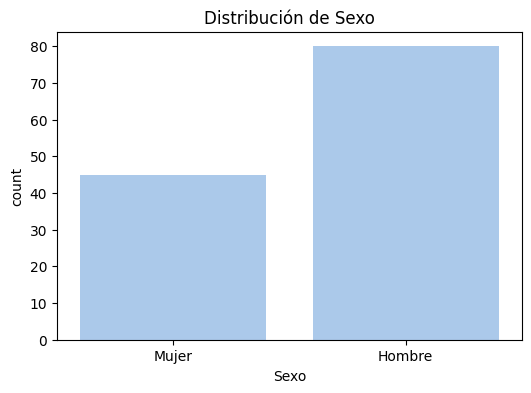

In [12]:
# Distribución Sexo
if "Sexo" in df.columns:
    plt.figure(figsize=(6,4))
    sns.countplot(x="Sexo", data=df)
    plt.title("Distribución de Sexo")
    plt.show()

Vemos como hay bastantes más hombres que mujeres, lo cual está un poco desbalanceado en cuanto al sexo. 

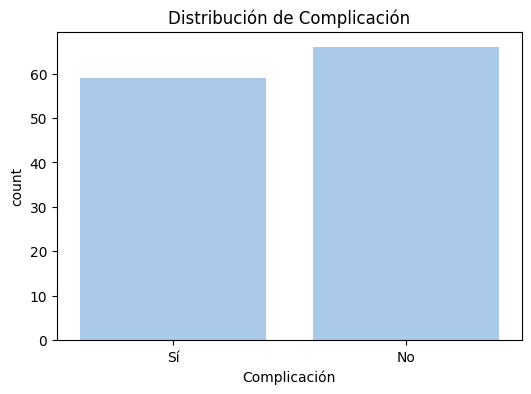

In [13]:
# Distribución Complicación
if "Complicación" in df.columns:
    plt.figure(figsize=(6,4))
    sns.countplot(x="Complicación", data=df)
    plt.title("Distribución de Complicación")
    plt.show()

Efectivamente, corroboramos que está bastante balanceada la clase objetivo. 

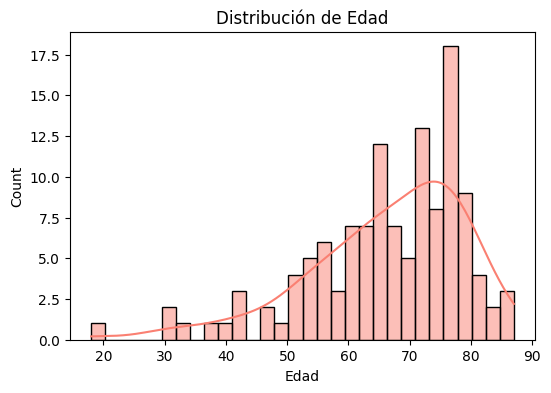

In [14]:
# Edad
if "Edad" in df.columns:
    plt.figure(figsize=(6,4))
    sns.histplot(df["Edad"], bins=30, kde=True, color="salmon")
    plt.title("Distribución de Edad")
    plt.show()

Podemos corroborar como hay más gente mayor que joven ya que de joven solo hay una persona por debajo de los 30 años. Los demás suelen estar sobre los 70 y donde más gente hay es en la década entre los 70 y 80. Por tanto, podemos decir que es un dataset donde predomina la edad avanzada. 

Vamos a continuar viendo los valores únicos de las variables multilabel y del tipo de cáncer, pero ahora de forma gráfica y contando su frecuencia. 

In [15]:
#funcion para contar etiquetas en columnas multilabel
def contar_etiquetas(df, columna):
    contador = Counter()
    for val in df[columna].dropna():
        if val.upper() == "X":
            continue
        for etiqueta in val.split(","):
            etiqueta = etiqueta.strip().lower()
            if etiqueta and etiqueta != "x":
                contador[etiqueta] += 1
    return pd.Series(contador).sort_values(ascending=False)

In [16]:
#el tipo de cancer si es single label porque solo puede ser de un tipo
conteo_cancer = df["Tipo de cáncer"].value_counts().sort_values(ascending=False) #contamos los tipos de cáncer
conteo_riesgo = contar_etiquetas(df, "Factor de riesgo") #contamos los factores de riesgo
conteo_pulmonar = contar_etiquetas(df, "Patología pulmonar") #contamos las patologías pulmonares
conteo_tipo_complicacion = contar_etiquetas(df, "Tipo de complicación") #contamos los tipos de complicación

In [17]:
print("\n Frecuencias — Tipo de Cáncer:")
for etiqueta, freq in conteo_cancer.items():
    print(f"- {etiqueta}: {freq}")

print("\n Frecuencias — Tipo de Complicación:")
for etiqueta, freq in conteo_tipo_complicacion.items():
    print(f"- {etiqueta}: {freq}")

print("\n Frecuencias — Factores de Riesgo:")
for etiqueta, freq in conteo_riesgo.items():
    print(f"- {etiqueta}: {freq}")

print("\n Frecuencias — Patologías Pulmonares:")
for etiqueta, freq in conteo_pulmonar.items():
    print(f"- {etiqueta}: {freq}")


 Frecuencias — Tipo de Cáncer:
- Adenocarcinoma: 56
- Epidermoide: 28
- X: 18
- Linfoma: 5
- Microcítico: 5
- Neuroendocrino: 3
- Timoma: 2
- Mesenquimal: 2
- Cáncer de célula no pequeña: 2
- Metástasis mama: 1
- Mesotelioma: 1
- Melanoma: 1
- Neoplasia pulmonar no filiada : 1

 Frecuencias — Tipo de Complicación:
- neumotórax: 37
- hemorragia: 17
- hemorragia leve: 8
- derrame pleural leve: 1

 Frecuencias — Factores de Riesgo:
- tabaquismo: 58
- hta: 44
- extabaquismo: 39
- dm: 10
- dislipemia: 7
- obesidad: 6
- aos: 6
- epoc: 4
- hipercolesterolemia: 3
- alcoholismo: 3
- cardiopatía: 3
- dm2: 2
- aneurisma esplénico: 1
- namc: 1
- craniofaringioma: 1
- exalcoholismo: 1
- frvc: 1
- dm1: 1
- hipertensión pulmonar: 1
- encefalopatía: 1
- hbp: 1
- hiperuricemia: 1
- scacest: 1
- macroglobulinemia de waldestrom: 1
- epilepsia: 1
- asma: 1
- cáncer de mama: 1
- vih: 1
- enfermedad de von willebrand: 1

 Frecuencias — Patologías Pulmonares:
- enfisema centrolobulillar: 20
- enfisema paras

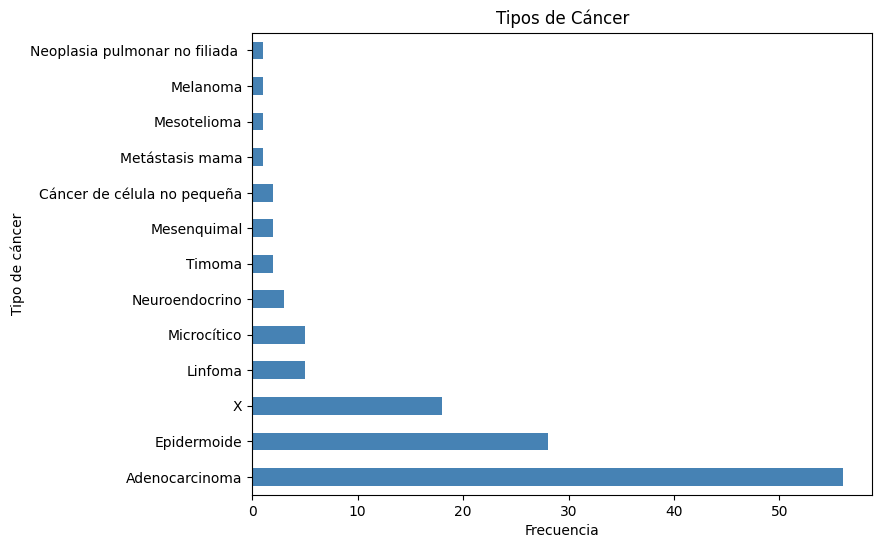

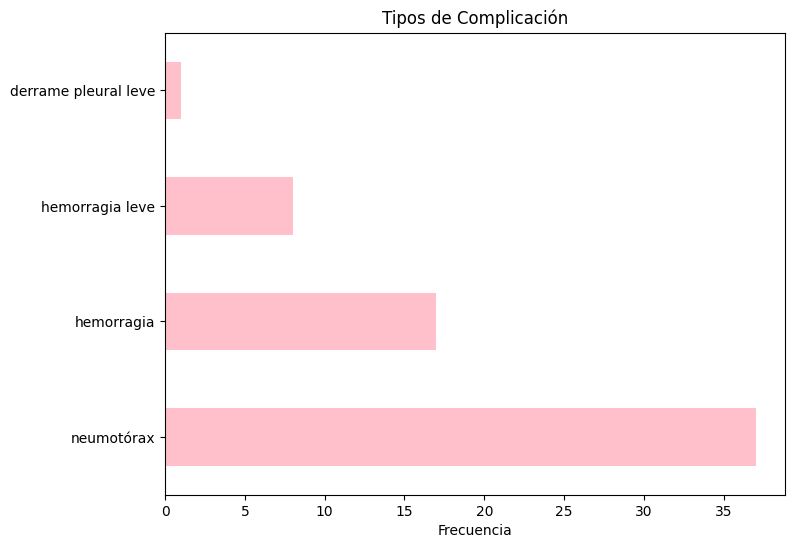

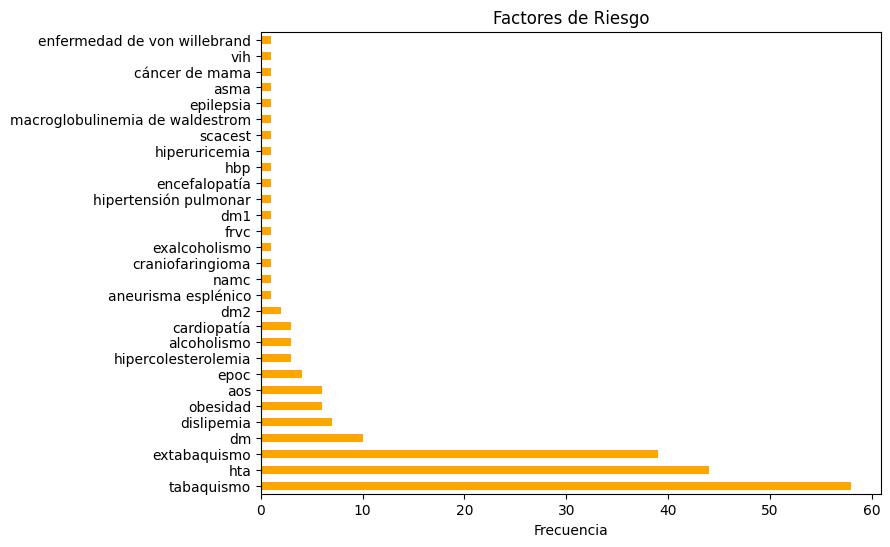

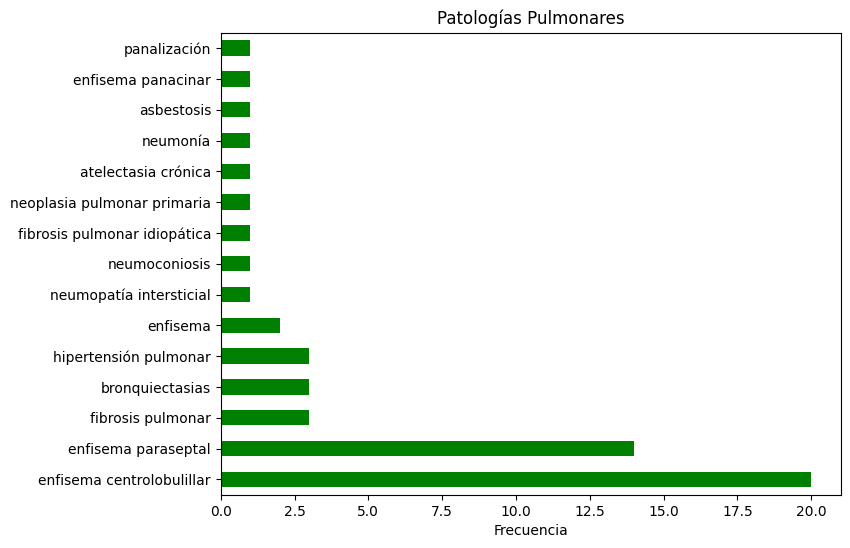

In [24]:
# Tipo de cáncer (single label)
plt.figure(figsize=(8, 6))
conteo_cancer.plot(kind='barh', color='steelblue')
plt.title("Tipos de Cáncer")
plt.xlabel("Frecuencia")
plt.show()

#Tipo de complicacion (multi-label)
plt.figure(figsize=(8, 6))
conteo_tipo_complicacion.plot(kind='barh', color='pink')
plt.title("Tipos de Complicación")
plt.xlabel("Frecuencia")
plt.show()

# Factores de riesgo (multi-label)
plt.figure(figsize=(8, 6))
conteo_riesgo.plot(kind='barh', color='orange')
plt.title("Factores de Riesgo")
plt.xlabel("Frecuencia")
plt.show()

# Patologías pulmonares (multi-label)
plt.figure(figsize=(8, 6))
conteo_pulmonar.plot(kind='barh', color='green')
plt.title("Patologías Pulmonares")
plt.xlabel("Frecuencia")
plt.show()

## Análisis de los volúmenes DICOM

In [ ]:
DICOM_DIR = "./../../volumenes/datos_anonimizados/" 

In [20]:
pacientes = [os.path.join(DICOM_DIR, p) for p in os.listdir(DICOM_DIR) if os.path.isdir(os.path.join(DICOM_DIR, p))]
print(f"Pacientes detectados: {len(pacientes)}")

Pacientes detectados: 125


In [21]:
resumen_dicom = [] #vamos a ir guardando un resumen de los volúmenes

Vamos a guardar toda la información que nos aporta un dicom, para ello cogeremos un al azar. 

In [22]:
#recorremos todos los pacientes
for paciente_path in pacientes:
    paciente_id = os.path.basename(paciente_path)

    # Recorremos todas subcarpetas y contar todos los archivos
    slices_paths = []
    for root, dirs, files in os.walk(paciente_path):
        for f in files:
            slices_paths.append(os.path.join(root, f))

    num_slices = len(slices_paths)
    if num_slices == 0:
        print(f" {paciente_id} no tiene slices encontrados.")
        continue

    # leemos solo una slice como ejemplo
    ejemplo_path = slices_paths[0] 
    try:
        ds = dcmread(ejemplo_path) 
        shape = ds.pixel_array.shape
        spacing = getattr(ds, "PixelSpacing", ["NA","NA"]) 
        thickness = getattr(ds, "SliceThickness", "NA")
    except Exception as e:
        print(f" Error leyendo ejemplo en {paciente_id}: {e}")
        shape = ("Error","Error")
        spacing = ("NA","NA")
        thickness = "NA"

    # Guardamos el resumen del paciente
    resumen_dicom.append({
        "Paciente": paciente_id,
        "Num_slices": num_slices,
        "Height": shape[0],
        "Width": shape[1],
        "Spacing_X": spacing[0],
        "Spacing_Y": spacing[1],
        "Spacing_Z": thickness
    })

 Error leyendo ejemplo en 92MASN: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.
 Error leyendo ejemplo en 93HESN: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.
 Error leyendo ejemplo en 94HCNSN: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.
 Error leyendo ejemplo en 95HASH: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.
 Error leyendo ejemplo en 100HNnSNH: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.


Dan 5 pacientes errores pero es por lo dicoms, cuando los pasemos a nifti ya no dan error. 


 Resumen de volúmenes DICOM:


,Paciente,Num_slices,Height,Width,Spacing_X,Spacing_Y,Spacing_Z
0,10MANX,292,768,768,0.375,0.375,1.0
1,11HASh,223,512,512,0.660156,0.660156,1.25
2,12HNSN,364,768,768,0.458333,0.458333,2.0
3,13HANX,259,512,512,0.78125,0.78125,1.25
4,15MANX,229,512,512,0.685547,0.685547,1.25
...,...,...,...,...,...,...,...
120,97HASN,287,768,768,0.47526,0.47526,1.0
121,98HESN,601,512,512,0.976562,0.976562,1.0
122,99MASH,193,512,512,0.78125,0.78125,1.25
123,74HCeNX,407,512,512,0.976562,0.976562,2.0



 Distribución de tamaños (Num_slices, Height, Width):
(292, 768, 768): 1 volúmenes
(223, 512, 512): 1 volúmenes
(364, 768, 768): 1 volúmenes
(259, 512, 512): 1 volúmenes
(229, 512, 512): 1 volúmenes
(300, 768, 768): 2 volúmenes
(220, 512, 512): 4 volúmenes
(215, 512, 512): 1 volúmenes
(67, 512, 512): 1 volúmenes
(271, 768, 768): 1 volúmenes
(545, 768, 768): 1 volúmenes
(231, 512, 512): 1 volúmenes
(54, 768, 768): 1 volúmenes
(208, 512, 512): 1 volúmenes
(301, 768, 768): 1 volúmenes
(291, 768, 768): 1 volúmenes
(327, 768, 768): 1 volúmenes
(2, 768, 768): 1 volúmenes
(296, 768, 768): 2 volúmenes
(222, 768, 768): 1 volúmenes
(463, 512, 512): 1 volúmenes
(328, 512, 512): 1 volúmenes
(609, 768, 768): 1 volúmenes
(222, 512, 512): 2 volúmenes
(286, 768, 768): 1 volúmenes
(51, 768, 768): 1 volúmenes
(290, 768, 768): 1 volúmenes
(473, 512, 512): 1 volúmenes
(285, 768, 768): 2 volúmenes
(303, 768, 768): 3 volúmenes
(488, 512, 512): 1 volúmenes
(174, 512, 512): 1 volúmenes
(151, 512, 512): 2 vol

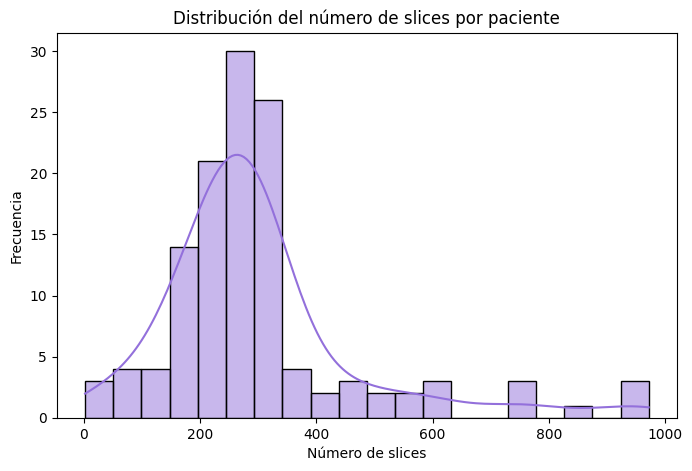


 Distribución de resoluciones (Height, Width) en el dataset:
(Height 512, Width 512): 70 volúmenes
(Height 768, Width 768): 50 volúmenes
(Height Error, Width Error): 5 volúmenes


In [23]:
if resumen_dicom:
    df_resumen = pd.DataFrame(resumen_dicom)
    print("\n Resumen de volúmenes DICOM:")
    display(df_resumen)

    # Distribución de shapes
    shapes_list = list(zip(df_resumen["Num_slices"], df_resumen["Height"], df_resumen["Width"]))
    from collections import Counter
    shapes_counter = Counter(shapes_list)
    print("\n Distribución de tamaños (Num_slices, Height, Width):")
    for shape, count in shapes_counter.items():
        print(f"{shape}: {count} volúmenes")

    # Histograma del número de slices
    import matplotlib.pyplot as plt
    import seaborn as sns
    sns.set_palette("pastel")
    plt.figure(figsize=(8,5))
    sns.histplot(df_resumen["Num_slices"], bins=20, kde=True, color="mediumpurple")
    plt.title("Distribución del número de slices por paciente")
    plt.xlabel("Número de slices")
    plt.ylabel("Frecuencia")
    plt.show()

    print("\n Distribución de resoluciones (Height, Width) en el dataset:")

    # Agrupamos y contamos
    resoluciones_counter = df_resumen.groupby(['Height', 'Width']).size().reset_index(name='Count')

    for idx, row in resoluciones_counter.iterrows():
        print(f"(Height {row['Height']}, Width {row['Width']}): {row['Count']} volúmenes")

else:
    print("\n No se generó resumen: no se encontraron volúmenes válidos.")

Vamos a comentar primero el resumen de los volumenes DICOM. Podemos observar como tneemos 125 pacientes y 7 columnas. Los pacientes son unívocos. Tenemos de cada paciente el número de slices que tiene cada volumen, es decir, la profundidad del volumen. Es muy variado, por lo que habrá que preprocesarlo. También se puede observar las dimensiones de altura y anchura. Los valores típicos en una CT es 512x512, el cual lo vemos en nuestros volúmenes, pero también vemos otro tipo que es el tamaño 768x758. Esto se debe a que el propio hospital tiene varias máquinas y dependiendo de la máquina que se haga la prueba puede variar la dimensionalidad del volumen. Después tenemos los espacion físicos en los tres ejes donde podemos ver que no es uniforme. Esto es importante para sacar radiómicas. 

Con respecto al histograma de la distribución del número de slices por paciente, tenemos en el eje X el número de slices y en el eje y la frecuencia, es decir, cuantos pacientes tienen esa cantidad de cortes.

Observamos como es una distribución asimétrica donde hay sesgo a la derecha, es decir, hacia más cantidad de slices. El pico principal está entre las 200 y las 300. Hay un paciente que llega a tener sobre unas 900 slices, poría considerarse un outlier. 

El dataset tiene dos tamaños de alto y ancho: 512x512 y 768x768 (sin contar el número de slices). Lo más logico va a ser reescalar y quedarnos con un tamaño fijo de 512x512. Se verá más en detalle en el apartado de preprocesamiento. 

Esta alta variabilidad habrá que tratarla con cuidad en el preprocesamiento ya que en una CNN 3D, los volúmenes de entrada deben tener un tamaño fijo, por lo que no se puede entrenar directamente con pacientes que tienen diferente número de slices. Este es nuestro caso, por lo que tenemos que aplicar alguna técnica para poder arreglar este problema.

Viendo el histograma de número de slices por pacientes, voy a empezar por la técnica de poner un número fijo de slices por pacientes. Los pacientes que les sobre slices, nos quedaremos con las centrales donde habrá más información. Los que les falten slices, vamos a hacer interpolación lineal (podriamos probar tambien con la bilineal). 